# Exploratory data analysis in retinal bipolar data with autoencoders

In this notebook, we will build a neural network that explores the retinal bipolar dataset for Shekhar et al., 2016 without using the manually annotated cell type labels.

## 1. Imports

In [ ]:
!pip install scprep

     |████████████████████████████████| 102kB 5.1MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data we used for the classifier.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [ ]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [ ]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

print(data_raw.head())
print(metadata.head())

                       0610005C13Rik  0610007P14Rik  ...  mt-Tw  mt-Ty
Bipolar1_CTCCTAAACAAG            0.0            0.0  ...    0.0    0.0
Bipolar1_CTCGAGAGGCGC            0.0            0.0  ...    0.0    0.0
Bipolar1_AGCCTAAAGTAC            0.0            0.0  ...    0.0    0.0
Bipolar1_CGTGAAAATCAA            0.0            0.0  ...    0.0    0.0
Bipolar1_CAACGTTCCGTA            0.0            0.0  ...    0.0    0.0

[5 rows x 15524 columns]
                       CLUSTER SUB-CLUSTER CELLTYPE
Bipolar1_CTCCTAAACAAG      3.0           3     BC5A
Bipolar1_CTCGAGAGGCGC      9.0           9     BC1B
Bipolar1_AGCCTAAAGTAC      5.0           5      BC6
Bipolar1_CGTGAAAATCAA      1.0           1   Rod BC
Bipolar1_CAACGTTCCGTA      5.0           5      BC6


In [ ]:
data = scprep.reduce.pca(data_raw, n_components=100, method='dense').to_numpy()
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])

## 3. Building an autoencoder

An **autoencoder** is a network that tries to reproduce its input. 

In this case, we will squeeze the data through a two-dimensional bottleneck (i.e. a extremely low-dimensional hidden layer) which we can use for visualization. Also, reducing the dimension from 100 down to 2 forces the network to only retain the most important information, which intrinsically behaves as a kind of denoising.

#### Create layers


In [ ]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = torch.randn(input_size, output_size).double().requires_grad_()
        self.bias = torch.randn(output_size).double().requires_grad_()
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        output = self.activation(output)
        return output

In [ ]:
# move data to pytorch tensors
data_tensor = torch.Tensor(data)
data_tensor

tensor([[ -2.8664,  16.1200,   4.3694,  ...,   1.0839,  -1.2292,   1.9792],
        [ -0.6686,  13.2155,  -4.8926,  ...,   2.8870,   0.7971,   1.2638],
        [  0.2967,   6.8555,  18.1911,  ...,  -1.2265,   1.8484,  -1.1975],
        ...,
        [ 39.5113,  -8.2089, -10.1642,  ...,   3.2547,   0.9991,  -2.8543],
        [  3.1393,  15.1062,   3.6947,  ...,  -3.0213,   0.9329,   0.4569],
        [ 42.9060,  -9.7928, -13.2521,  ...,   0.3613,   1.5019,   2.0353]])

### Method 1

In [ ]:
# layers will be input -> 100 -> 2 --> 100 -> output
# first hidden layer of size 100
hidden_layer1 = layer(input_size=data_tensor.shape[1], 
                      output_size= 100, 
                      activation=nn.ReLU())

# we won't apply a nonlinear activation to the 2D middle layer
hidden_layer2 = layer(input_size=100, 
                      output_size=2,
                      activation=None)

# last hidden layer of size 100
hidden_layer3 = layer(input_size=2,
                         output_size=100, 
                         activation=nn.ReLU())

# the output should be the same size as the input
output = layer(input_size=100,
              output_size=data_tensor.shape[1], 
               activation=None)

### Method 2

PyTorch provides the linear layers we've been manually defining in its `nn` module (the same place we've been getting our activation functions) as [`nn.Linear()`](https://pytorch.org/docs/stable/nn.html#linear), so let's go ahead and repeat the layer creation step above using this new knowledge.


In [ ]:
# layers will be input -> 100 -> 2 --> 100 -> output

# first hidden layer of size 100
hidden_layer1 = nn.Linear(in_features=data_tensor.shape[1], 
                      out_features= 100)

# second middle layer
hidden_layer2 = nn.Linear(in_features=100, 
                      out_features=2)

# last hidden layer of size 100
hidden_layer3 = nn.Linear(in_features=2,
                        out_features=100)

# the output should be the same size as the input
output_layer4 = nn.Linear(in_features=100,
              out_features=data_tensor.shape[1])

As you may have noticed, we did not specify our activation functions this time. Since this is separate from the `nn.Linear` class, we will have to define them outside our layers. 

In [ ]:
activation_1 = nn.ReLU()
activation_3 = nn.ReLU()

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for Pytorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters, rather than having to list them ourselves.

In [ ]:
autoencoder1 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

`nn.Sequential` ties together our layers and creates a model. The data passes through the model in the order we place the layers. We can print out the model to see the list of layers.

In [ ]:
print(autoencoder1)

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): Linear(in_features=2, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
)


#### Define Optimizer

As in the classifier, we'll start with a SGD optimizer.

In [ ]:
learning_rate = 0.001

optimizer = optim.SGD(autoencoder1.parameters(),
                       lr=learning_rate)


#### Loss function

Since this is an autoencoder, we don't have prior assumptions on the output (like it being a discrete probability distribution, as it was in classification) so we can't use fancy loss functions like the cross entropy. Instead, we'll just compute the mean squared error of the output compared to the input.

In [ ]:
loss_fcn = nn.MSELoss()

#### Train the network

Let's move our hyperparameters to a function that we can reuse to train other models

In [ ]:
def train_model(model, n_epochs=10):

    batch_size=100
    learning_rate = 0.001
    optimizer = optim.SGD(model.parameters(),
                        lr=learning_rate)
    loss_fcn = nn.MSELoss()

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(data_tensor.shape[0])
        data_randomized = data_tensor[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output = model(data_batch)

            # get loss
            loss = loss_fcn(output, data_batch)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()

    return model

In [ ]:
autoencoder1 = train_model(autoencoder1)

Step: 100 Loss: 10.872
Step: 200 Loss: 10.662
Step: 300 Loss: 9.898
Step: 400 Loss: 9.655
Step: 500 Loss: 8.947
Step: 600 Loss: 8.657
Step: 700 Loss: 8.825
Step: 800 Loss: 8.530
Step: 900 Loss: 7.875
Step: 1000 Loss: 7.507
Step: 1100 Loss: 7.550
Step: 1200 Loss: 8.014
Step: 1300 Loss: 7.445
Step: 1400 Loss: 8.178
Step: 1500 Loss: 7.783
Step: 1600 Loss: 7.544
Step: 1700 Loss: 7.480
Step: 1800 Loss: 7.828
Step: 1900 Loss: 7.133
Step: 2000 Loss: 7.529
Step: 2100 Loss: 7.152


#### Visualize the output

Rather than evaluating our model with our data like we did with the classifier, we can now use our model to evaluate our data (aka exploratory data analysis)!  Autoencoder networks are very useful in exploratory data analysis.

In [ ]:
print(autoencoder1[:3])

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)


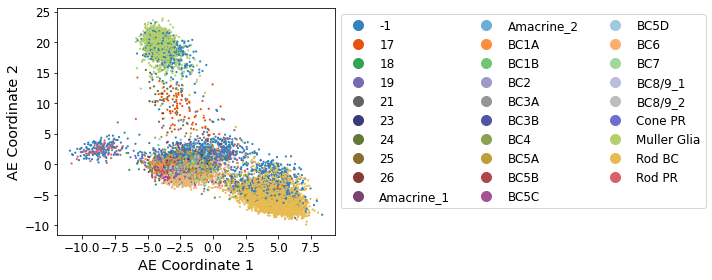

In [ ]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()


scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Exercise

Try retraining the network for more than just 10 epochs and plot it again. 

In [ ]:
# =======
# Retrain the network
autoencoder1 = train_model(
    autoencoder1,
    n_epochs = 50
)
# =======

Step: 100 Loss: 7.544
Step: 200 Loss: 7.337
Step: 300 Loss: 7.311
Step: 400 Loss: 7.066
Step: 500 Loss: 6.971
Step: 600 Loss: 7.064
Step: 700 Loss: 7.045
Step: 800 Loss: 7.451
Step: 900 Loss: 7.013
Step: 1000 Loss: 7.120
Step: 1100 Loss: 6.683
Step: 1200 Loss: 7.101
Step: 1300 Loss: 6.649
Step: 1400 Loss: 6.718
Step: 1500 Loss: 7.155
Step: 1600 Loss: 6.530
Step: 1700 Loss: 7.077
Step: 1800 Loss: 7.078
Step: 1900 Loss: 6.919
Step: 2000 Loss: 7.401
Step: 2100 Loss: 6.854
Step: 2200 Loss: 6.734
Step: 2300 Loss: 6.839
Step: 2400 Loss: 6.867
Step: 2500 Loss: 6.479
Step: 2600 Loss: 6.531
Step: 2700 Loss: 7.157
Step: 2800 Loss: 7.348
Step: 2900 Loss: 6.576
Step: 3000 Loss: 6.993
Step: 3100 Loss: 6.854
Step: 3200 Loss: 6.938
Step: 3300 Loss: 6.466
Step: 3400 Loss: 6.740
Step: 3500 Loss: 6.449
Step: 3600 Loss: 6.805
Step: 3700 Loss: 6.625
Step: 3800 Loss: 6.532
Step: 3900 Loss: 6.184
Step: 4000 Loss: 6.362
Step: 4100 Loss: 6.552
Step: 4200 Loss: 6.265
Step: 4300 Loss: 6.551
Step: 4400 Loss: 6.6

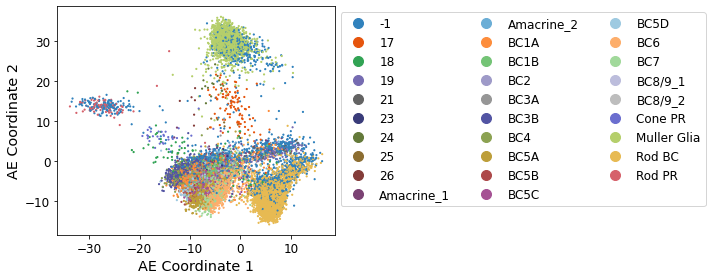

In [ ]:
with torch.no_grad():
    ae_coordinates = autoencoder1[:3](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Discussion

1. What do you notice about the visualization? 
  - visualization separates in a similar way to PCA - the Muller Glia are clearly separated from the bipolar cells, and then the Rod BCs are less clearly separated from the Cone BCs. It does seem to lack some resolution in the detailed subtypes of the cone bipolar cells. After continuing training for further epochs, the cell types started to separate more clearly.
2. How does this compare to the visualizations you have seen with PCA, t-SNE, UMAP and PHATE?
  - the autoencoder is a little more noisy than PHATE or UMAP, but seems to capture both the cluster structure and the global strucutre of the data quite well

## Exercise 4 - Activation functions on the visualization layer

Notice we did not use an acitvation function for the hidden layer we were going to visualize.

Repeat the process with other activation functions like `nn.ReLU`, `nn.Sigmoid`, `nn.Tanh`, etc. You can see more in the [PyTorch activation function documentions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). 

Note how the visualization changes. Has the data changed at all?

In [ ]:
# ======
# choose from nn.Sigmoid(), nn.Tanh() and others in the documentation
activation_2 = nn.Sigmoid()
# ======

autoencoder2 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            activation_2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

In [ ]:
autoencoder2 = train_model(autoencoder2)

Step: 100 Loss: 10.190
Step: 200 Loss: 9.709
Step: 300 Loss: 9.877
Step: 400 Loss: 9.800
Step: 500 Loss: 9.385
Step: 600 Loss: 9.987
Step: 700 Loss: 9.517
Step: 800 Loss: 9.090
Step: 900 Loss: 9.287
Step: 1000 Loss: 9.087
Step: 1100 Loss: 8.758
Step: 1200 Loss: 8.899
Step: 1300 Loss: 9.179
Step: 1400 Loss: 9.159
Step: 1500 Loss: 8.811
Step: 1600 Loss: 9.865
Step: 1700 Loss: 9.004
Step: 1800 Loss: 9.056
Step: 1900 Loss: 9.286
Step: 2000 Loss: 9.026
Step: 2100 Loss: 8.663


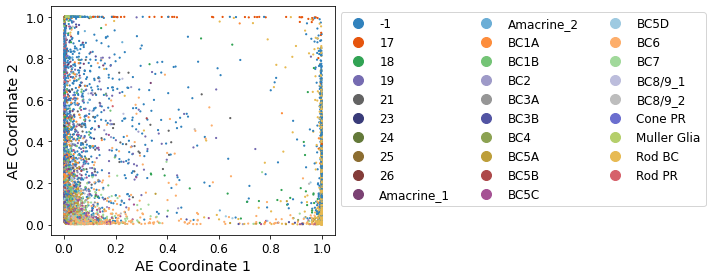

In [ ]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates2 = autoencoder2[:4](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates2, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

## Exercise 5 - Activation functions on the wide hidden layers

Now turn the activation for the visualization layer back to None, but experiment with the activation function for the 100-dimensional layers.

Is there a change? Why?
  - Yes, the embedding changes quite substantially (though less than when we applied the nonlinearity to the bottleneck layer itself). This is because the different nonlinearities affect how well the network learns the data, which in turn affects the quality of the embedding

In [ ]:
# ======
# choose from nn.Sigmoid(), nn.Tanh() and others in the documentation
activation_1 = nn.Sigmoid()
activation_3 = nn.Sigmoid()
# ======

autoencoder3 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

In [ ]:
autoencoder3 = train_model(autoencoder3)

Step: 100 Loss: 8.182
Step: 200 Loss: 8.694
Step: 300 Loss: 8.202
Step: 400 Loss: 8.183
Step: 500 Loss: 8.355
Step: 600 Loss: 8.671
Step: 700 Loss: 7.434
Step: 800 Loss: 7.998
Step: 900 Loss: 7.870
Step: 1000 Loss: 8.592
Step: 1100 Loss: 8.198
Step: 1200 Loss: 7.746
Step: 1300 Loss: 7.899
Step: 1400 Loss: 7.737
Step: 1500 Loss: 8.426
Step: 1600 Loss: 7.508
Step: 1700 Loss: 8.100
Step: 1800 Loss: 7.894
Step: 1900 Loss: 7.665
Step: 2000 Loss: 7.632
Step: 2100 Loss: 7.687


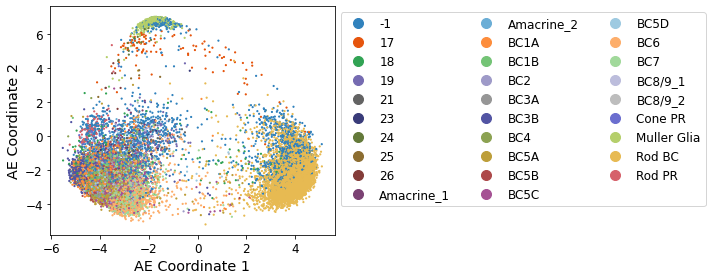

In [ ]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
    ae_coordinates3 = autoencoder3[:3](data_tensor).numpy()

scprep.plot.scatter2d(ae_coordinates3, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

In [ ]:
! rm data.pickle.gz
! rm metadata.pickle.gz